In [31]:
import sys
sys.path.append('../')

import copy
import glob

from typing import Tuple, Union, List
import pandas as pd
import numpy as np
import networkx as nx
from tqdm.notebook import tqdm as tqdm

from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope
from hyperopt.pyll.stochastic import sample as ho_sample

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

from torchmetrics import R2Score

import torch_geometric as pyg
from torch_geometric.nn import GCNConv
from torch_geometric.utils.convert import from_networkx
from torch_geometric.data import InMemoryDataset
import torch_scatter
import pytorch_forecasting as pyf

from src.utils import *

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from IPython.display import clear_output

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(17)

device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
G = nx.readwrite.read_gpickle('data/network.gpickle')

In [33]:
# Pytorch geometric Data object. For now used only for storing node embedding. 
# Supposed to be used in the future for obtaining node embeddings.
pyg_data = from_networkx(G, group_edge_attrs=['dist'])
pyg_data.to(device);
pyg_data

Data(edge_index=[2, 442], id=[233], lat=[233], lon=[233], population=[233], jobs=[233], labor_force_rate=[233], housing_sales_num_Total:=[233], housing_sales_num_Total:!!Less than $10,000=[233], housing_sales_num_Total:!!$10,000 to $14,999=[233], housing_sales_num_Total:!!$15,000 to $19,999=[233], housing_sales_num_Total:!!$20,000 to $24,999=[233], housing_sales_num_Total:!!$25,000 to $29,999=[233], housing_sales_num_Total:!!$30,000 to $34,999=[233], housing_sales_num_Total:!!$35,000 to $39,999=[233], housing_sales_num_Total:!!$40,000 to $49,999=[233], housing_sales_num_Total:!!$50,000 to $59,999=[233], housing_sales_num_Total:!!$60,000 to $69,999=[233], housing_sales_num_Total:!!$70,000 to $79,999=[233], housing_sales_num_Total:!!$80,000 to $89,999=[233], housing_sales_num_Total:!!$90,000 to $99,999=[233], housing_sales_num_Total:!!$100,000 to $124,999=[233], housing_sales_num_Total:!!$125,000 to $149,999=[233], housing_sales_num_Total:!!$150,000 to $174,999=[233], housing_sales_num_T

In [34]:
df = pd.read_csv('data/mta_ridership_pivot.csv')
df

,1 AV,103 ST,104 ST,110 ST,111 ST,116 ST,121 ST,125 ST,14 ST,145 ST,...,WALL ST,WHITLOCK AV,WILSON AV,WINTHROP ST,WOODHAVEN BLVD,WOODLAWN,YORK ST,ZEREGA AV,weekday,time_idx
0,191.0,317.0,20.0,239.0,70.0,84.0,216.0,782.0,414.0,212.0,...,53.0,35.0,299.0,224.0,800.0,362.0,7309.0,44.0,5,0
1,159.0,366.0,19.0,229.0,87.0,65.0,213.0,822.0,346.0,211.0,...,46.0,20.0,253.0,188.0,696.0,349.0,447.0,47.0,6,1
2,310.0,662.0,36.0,399.0,145.0,139.0,407.0,1226.0,773.0,333.0,...,218.0,55.0,478.0,542.0,1079.0,663.0,867.0,100.0,0,2
3,390.0,678.0,54.0,368.0,157.0,157.0,420.0,1187.0,752.0,394.0,...,227.0,48.0,461.0,573.0,1430.0,686.0,896.0,123.0,1,3
4,402.0,680.0,50.0,407.0,143.0,177.0,445.0,1116.0,756.0,411.0,...,238.0,52.0,454.0,538.0,1195.0,696.0,894.0,121.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,594.0,916.0,463.0,579.0,372.0,156.0,273.0,1741.0,1176.0,624.0,...,450.0,62.0,593.0,762.0,2268.0,875.0,1430.0,199.0,0,359
360,629.0,856.0,513.0,504.0,180.0,176.0,256.0,1699.0,1147.0,595.0,...,463.0,75.0,545.0,761.0,1724.0,872.0,1487.0,193.0,1,360
361,669.0,886.0,467.0,458.0,325.0,157.0,246.0,677.0,1089.0,586.0,...,402.0,71.0,566.0,797.0,465.0,769.0,1418.0,203.0,2,361
362,585.0,803.0,441.0,511.0,363.0,116.0,241.0,1043.0,1001.0,577.0,...,347.0,67.0,513.0,724.0,1669.0,767.0,1349.0,185.0,3,362


In [35]:
stations = df.columns[:-2].to_list()
targets = df.columns[:-2].to_list()
# targets are just stations ridership
features = targets
extra_features = ['weekday']
# days and local features can be added

In [36]:
len(stations)

227

In [37]:
pyg_data = pyg_data.subgraph(torch.tensor([pyg_data.id.index(x) for x in stations]))
pyg_data.id = stations
pyg_data

Data(edge_index=[2, 416], id=[227], lat=[227], lon=[227], population=[227], jobs=[227], labor_force_rate=[227], housing_sales_num_Total:=[227], housing_sales_num_Total:!!Less than $10,000=[227], housing_sales_num_Total:!!$10,000 to $14,999=[227], housing_sales_num_Total:!!$15,000 to $19,999=[227], housing_sales_num_Total:!!$20,000 to $24,999=[227], housing_sales_num_Total:!!$25,000 to $29,999=[227], housing_sales_num_Total:!!$30,000 to $34,999=[227], housing_sales_num_Total:!!$35,000 to $39,999=[227], housing_sales_num_Total:!!$40,000 to $49,999=[227], housing_sales_num_Total:!!$50,000 to $59,999=[227], housing_sales_num_Total:!!$60,000 to $69,999=[227], housing_sales_num_Total:!!$70,000 to $79,999=[227], housing_sales_num_Total:!!$80,000 to $89,999=[227], housing_sales_num_Total:!!$90,000 to $99,999=[227], housing_sales_num_Total:!!$100,000 to $124,999=[227], housing_sales_num_Total:!!$125,000 to $149,999=[227], housing_sales_num_Total:!!$150,000 to $174,999=[227], housing_sales_num_T

In [38]:
from sklearn.preprocessing import StandardScaler


class StandardScaler(nn.Module):
    def fit(self, x):
        self.mean = x.mean(0, keepdim=True)
        self.std = x.std(0, unbiased=False, keepdim=True)
        
    def transform(self, x):
        x -= self.mean
        x /= (self.std + 1e-7)
        return x

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

    def inverse_transform(self, x):
        x *= (self.std + 1e-7)
        x += self.mean
        return x

    def to(self, device):
        super().to(device)
        self.mean = self.mean.to(device)
        self.std = self.std.to(device)
        return self


class SnapshotTimeSeriesDataset(Dataset):
    def __init__(self, snapshots: pd.DataFrame, pyg_data: pyg.data.Data, 
     snapshot_features_cols, snapshot_target_cols, meta_features=None, encoder_length=14, 
      horizon_length=1, normalize=True):
        self.X = torch.tensor(snapshots[snapshot_features_cols].values, dtype=torch.float32)
        self.y = torch.tensor(snapshots[snapshot_target_cols].values, dtype=torch.float32)
        self.pyg_data = pyg_data
        self.meta_features = meta_features

        if meta_features:
            self.meta_X = torch.tensor(snapshots[meta_features].values, dtype=torch.float32)

        self.window = encoder_length
        self.horizon = horizon_length
        self.shape = self.__getshape__()
        self.size = self.__getsize__()

        if normalize:
            self.feature_scaler = StandardScaler()
            self.target_scaler = StandardScaler()
            self.normalize()
    
    def normalize(self):
        self.X = self.feature_scaler.fit_transform(self.X)
        self.y = self.target_scaler.fit_transform(self.y)

    def __getitem__(self, index):
        X = self.X[index: index + self.window].unsqueeze(-1)
        y = self.y[index + self.window: index + self.window + self.horizon].reshape(-1)

        # if self.meta_features:
        #     meta_X = self.meta_X[index: index + self.window]
        #     return torch.cat((X, meta_X), dim=1), y

        if self.meta_features:
            return X, y, self.pyg_data.edge_index, self.meta_features

        return X, y, self.pyg_data.edge_index

    def __len__(self):
        return len(self.X) - self.window - self.horizon + 1
    
    def __getshape__(self):
        return (self.__len__(), *self.__getitem__(0)[0].shape)
    
    def __getsize__(self):
        return (self.__len__())

In [39]:
dataset = SnapshotTimeSeriesDataset(df, pyg_data, features, targets)
dataset[0][0].shape, dataset[0][1].shape, dataset[0][2].shape

(torch.Size([14, 227, 1]), torch.Size([227]), torch.Size([2, 416]))

In [40]:
def make_datasets(df, pyg_data, **kwargs):
    train_df = df.iloc[:int(len(df) * 0.7)]
    val_df = df.iloc[int(len(df) * 0.7): int(len(df) * 0.85)]
    test_df = df.iloc[int(len(df) * 0.85):]

    train_ds = SnapshotTimeSeriesDataset(train_df, pyg_data, features, targets, **kwargs)
    val_ds = SnapshotTimeSeriesDataset(val_df, pyg_data, features, targets, **kwargs)
    test_ds = SnapshotTimeSeriesDataset(test_df, pyg_data, features, targets, **kwargs)

    return train_ds, val_ds, test_ds


def make_dataloaders(train_ds, val_ds, test_ds, batch_size=32, **kwargs):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)
    test_loader = DataLoader(test_ds, batch_size=batch_size)

    return train_loader, val_loader, test_loader

In [41]:
train_ds, val_ds, test_ds = make_datasets(df, pyg_data, normalize=True)
train_loader, val_loader, test_loader = make_dataloaders(train_ds, val_ds, test_ds)

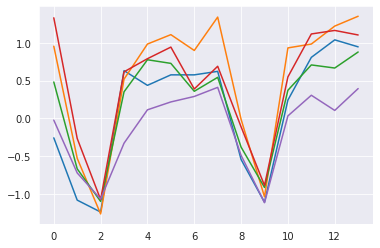

In [42]:
kek = [x.shape for x in next(iter(train_loader))]
plt.plot(next(iter(train_loader))[0][0, :, :5, 0].detach().numpy())
plt.show()

In [43]:
from statistics import mean

scaler = copy.deepcopy(dataset.target_scaler).to(device)

def test(model, loader, loss_fn, score_fn, device) -> Tuple[float, float]:
    """ returns average loss and score
    """
    model.eval()

    losses = []

    outs, ys = [], []
    with torch.no_grad():
        for X, y, edge_index in loader:
            X_gpu, y_gpu = X.to(device), y.to(device)
            out = model(X_gpu, edge_index)

            outs.append(out)
            ys.append(y_gpu)

            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
    
    ys = torch.vstack(ys)
    outs = torch.vstack(outs)

    ys = scaler.inverse_transform(ys)
    outs = scaler.inverse_transform(outs)

    day_scores = [score_fn(ys[day], outs[day]).item() for day in range(len(ys))]
    return mean(losses), mean(day_scores)


def train(model, train_loader, val_loader,
    loss_fn, score_fn, optimizer, device, scheduler=None, num_epochs=10, plot=True, plot_update_freq=5):
    """ returns best model on validation
    """

    train_losses = []
    val_losses = []
    val_scores = []

    best_val_score = -torch.inf
    best_model = None

    for epoch in range(num_epochs + 1):
        model.train()
        losses = []
        for X, y, edge_index in train_loader:
            optimizer.zero_grad()
            X_gpu, y_gpu = X.to(device), y.to(device)
            out = model(X_gpu, edge_index)
            loss = loss_fn(out, y_gpu)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            
        if scheduler is not None:
            scheduler.step()

        train_losses.append(mean(losses))
        val_loss, val_score = test(model, val_loader, loss_fn, score_fn, device)
        val_losses.append(val_loss)
        val_scores.append(val_score)

        if val_score > best_val_score:
            best_val_score = val_score
            best_model = copy.deepcopy(model)

        if plot and epoch > 0 and epoch % plot_update_freq == 0:
            clear_output(True)
            _, axes = plt.subplots(1, 2, figsize=(20, 6))
            
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=train_losses, label='Train', color='blue')
            sns.lineplot(ax=axes[0], x=range(epoch + 1), y=val_losses, label='Val', color='red')
            axes[0].set_xlabel('Epoch')
            axes[0].set_ylabel('Loss')
            axes[0].legend()

            sns.lineplot(ax=axes[1], x=range(epoch + 1), y=val_scores, label='Val', color='red')
            # sns.lineplot(ax=axes[1], x=range(epoch + 1), y=train_scores, label='Train', color='blue')
            axes[1].set_xlabel('Epoch')
            axes[1].set_ylabel('Score')
            axes[1].legend()

            plt.show()
        
        # print(f'Epoch {epoch}, Loss: {train_losses[-1]:.4f}, Val loss: {val_loss:.4f}, Val R2: {val_scores[-1]:.4f}')
    return best_model

In [44]:
class MeanValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X, *args):
        # print(X.shape)
        out = torch.mean(X, dim=1)[:, :, 0]
        return out

class LastValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X, *args):
        out = X[:, -1, :, 0]
        return out

class PreviousWeekValueModel(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.param = nn.Parameter(torch.rand(1))
    
    def forward(self, X):
        out = X[:, -7, :, 0]
        return out

class LinearModel(nn.Module):
    def __init__(self, encoder_length=14, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.window = encoder_length
        self.lin = nn.Linear(self.window, 1)
    
    def forward(self, X, *args):
        X = X.transpose(1, 2)
        X = X.reshape(X.shape[0], X.shape[1], -1)
        out = torch.squeeze(self.lin(X))
        return out

class LSTMModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, hidden_size=32, num_layers=1, bidirectional=True, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.in_channels, hidden_size=self.hidden_size, num_layers=self.num_layers,
            batch_first=True, bidirectional=self.bidirectional)
        self.lin = nn.Linear(self.hidden_size * 2 if self.bidirectional else 1, 1)
    
    def forward(self, X, *args):
        X = X.transpose(1, 2)
        batch_size = len(X)
        feats = X.shape[1]
        X = X.reshape(-1, self.window, self.in_channels)
        out, (hn, cn) = self.rnn(X)
        out = out[:, -1, :]
        out = out.reshape(batch_size, feats, -1)
        # print(hn.shape)
        # fuck()
        out = torch.squeeze(self.lin(out))
        return out

class GNN_LSTMModel(nn.Module):
    def __init__(self, encoder_length=14, in_channels=1, gnn_hidden_dim=32,
     lstmcell_hidden_size=16, lstm_num_layers=1, bidirectional=False, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.in_channels = in_channels
        self.window = encoder_length
        
        self.gnn_hidden_dim = gnn_hidden_dim
        self.graph_layer = GCNConv(self.in_channels, self.gnn_hidden_dim)

        self.lstmcell_hidden_size = lstmcell_hidden_size
        self.lstm_num_layers = lstm_num_layers
        self.bidirectional = bidirectional
        self.rnn = nn.LSTM(input_size=self.gnn_hidden_dim, hidden_size=self.lstmcell_hidden_size, 
            num_layers=self.lstm_num_layers, batch_first=True, bidirectional=self.bidirectional)

        self.lin = nn.Linear((2 if self.bidirectional else 1) * self.lstmcell_hidden_size, 1)
    
    def forward(self, X, edge_index):
        """X has shape [N, window, nodes_num, in_channels]
        edge_index has shape [N, 2, edges_num]

        Args:
            X (torch.Tensor): batched input features
            edge_index (torch.Tensor): adj list 

        Returns:
            torch.Tensor: predictions
        """
        batch_size = X.shape[0]
        nodes_num = X.shape[2]

        X = X.reshape(-1, nodes_num, self.in_channels)
        out = torch.stack([self.graph_layer(X[snap], edge_index[snap // self.window]) for snap in range(len(X))])
        # out = self.graph_layer(X, edge_index[0])
        out = out.reshape(batch_size, self.window, nodes_num, self.gnn_hidden_dim)

        out = out.transpose(1, 2)
        out = out.reshape(-1, self.window, self.gnn_hidden_dim)
        
        out, (hn, cn) = self.rnn(out)
        out = out[:, -1, :]
        out = out.reshape(batch_size, nodes_num, -1)
        # print(out.shape)
        # fuck()
        out = torch.squeeze(self.lin(out))
        return out

In [45]:
class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

In [46]:
NEIGHBORS_NUM = 25
loss_fn = nn.MSELoss().to(device)
score = R2Score().to(device)
model = GNN_LSTMModel().to(device)

def run(model):
    results = dict()

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
        
    model = train(model, train_loader, val_loader,
        loss_fn, score, optimizer, device, num_epochs=50, plot=True, plot_update_freq=5)

    # scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 20, gamma=0.9)

    test_loss, test_score = test(model, test_loader, loss_fn, score, device)

    # for name, param in model.named_parameters():
        # print(name, param)

    if test_score is not torch.nan:
        results[f'{model.__class__.__name__}'] = test_score
    print(f'Type: {model.__class__.__name__}, Test loss: {test_loss:.2f}, Test score: {test_score:.4f}')

    return model

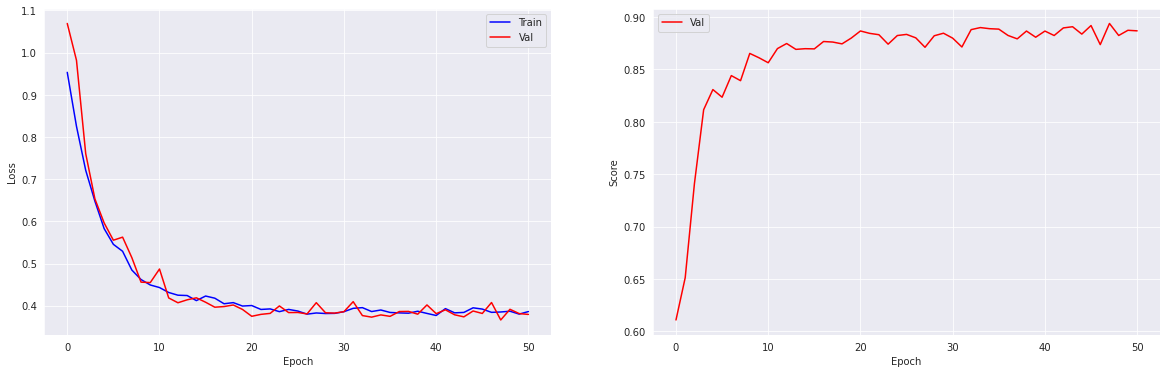

Type: GNN_LSTMModel, Test loss: 0.46, Test score: 0.8324


/home/eldervald/miniconda3/envs/traffic/lib/python3.7/site-packages/torch/nn/modules/rnn.py:762: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755953518/work/aten/src/ATen/native/cudnn/RNN.cpp:926.)
  self.dropout, self.training, self.bidirectional, self.batch_first)


In [47]:
model = run(model)

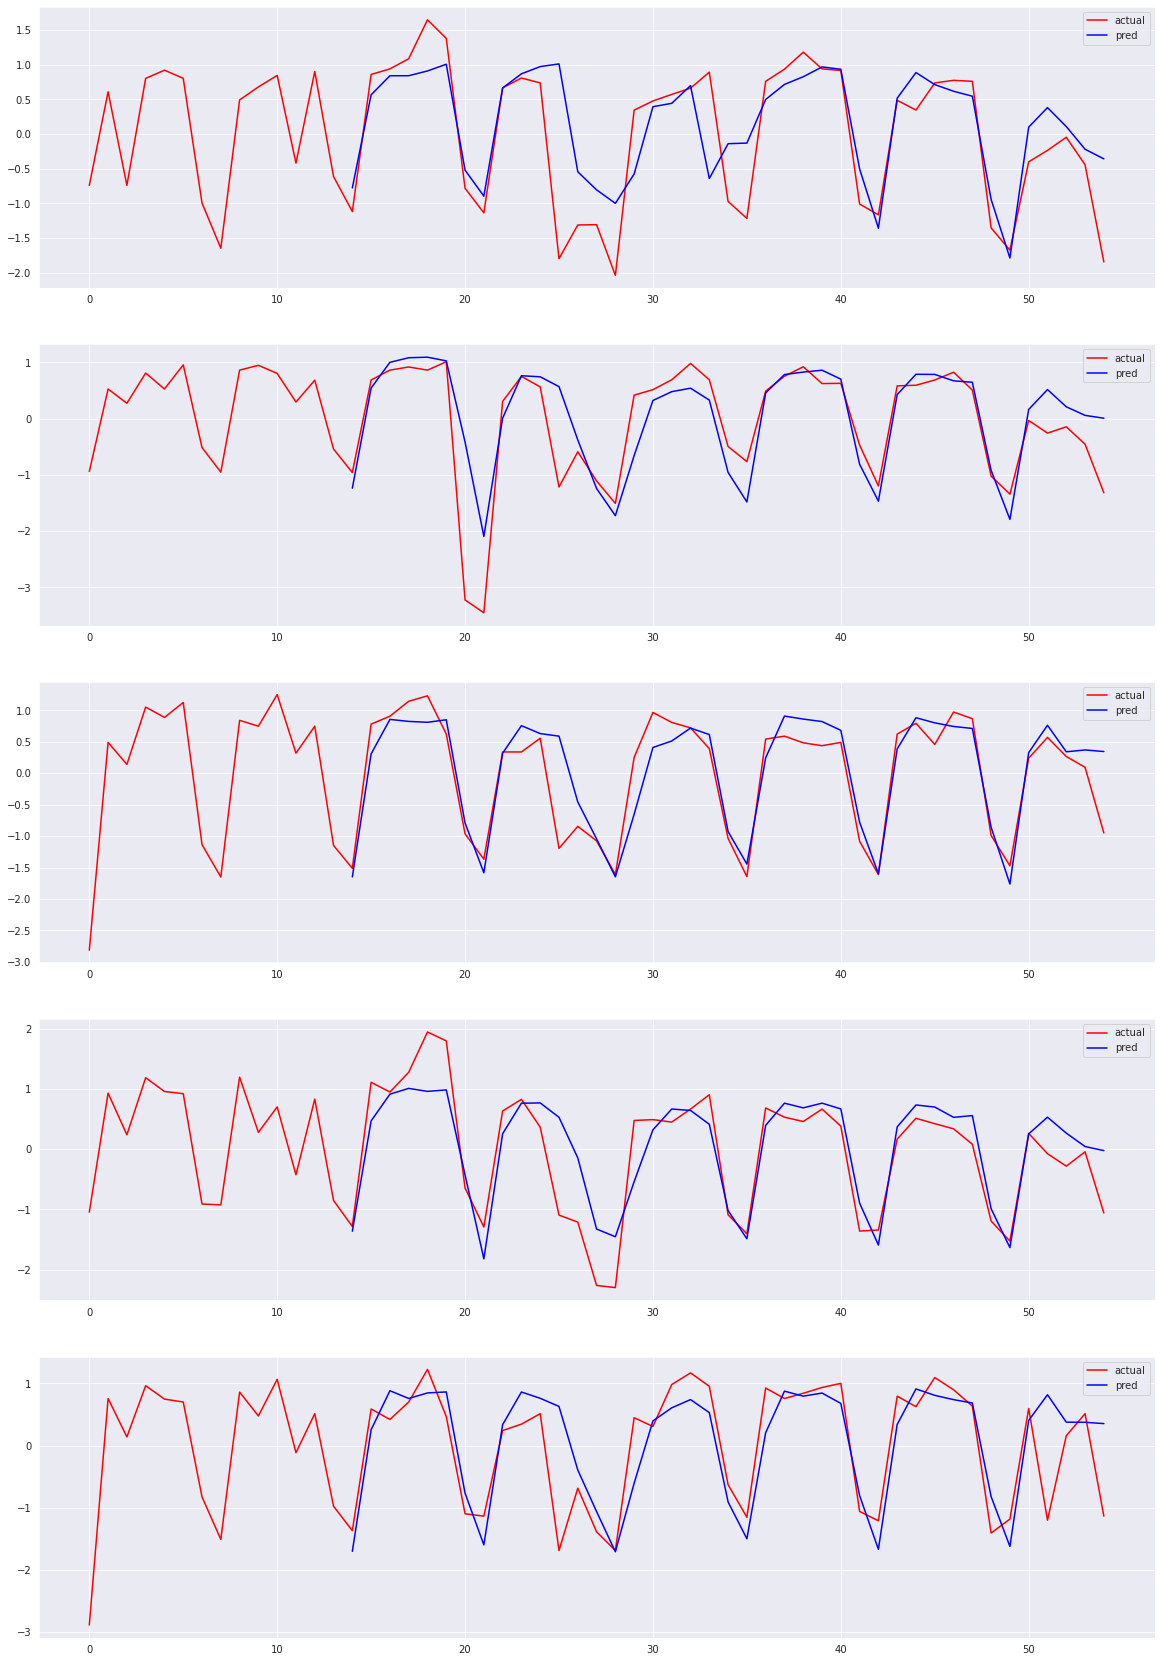

In [48]:
def evaluate_plot(nodes_num=5):
    outs, ys = [], []
    fig, axes = plt.subplots(nodes_num, figsize=(20, nodes_num * 6))
    
    with torch.no_grad():
        for X, y, edge_index in test_loader:
            # X = X[:, :, :nodes_num]
            # y = y[:, :nodes_num]
            X_gpu, y_gpu = X.to(device), y.to(device)
            out = model(X_gpu, edge_index)

            outs.append(out)
            ys.append(y_gpu)
        
        ys = torch.vstack(ys).detach().cpu().numpy()
        outs = torch.vstack(outs).detach().cpu().numpy()

        for node in range(nodes_num):

            # axes[node].figure(figsize=(20,6))
            axes[node].plot(test_ds.X[:, node].detach().numpy(), label='actual', c='r')
            axes[node].plot(np.arange(test_ds.window, test_ds.window + len(outs)), outs[:, node], label='pred', c='b')
            axes[node].legend()
        plt.show()

evaluate_plot()